<a href="https://colab.research.google.com/github/SushantVij/NLP-CV-IOT-UCS657-/blob/main/RISE11_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

 Load the dataset

In [3]:
df = pd.read_csv('/content/train.csv')

Preprocess text data

In [4]:

# Preprocess text
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
#Define a parallel text preprocessing function
from joblib import Parallel, delayed


    Tokenize, lowercase, remove non-alphanumeric, and lemmatize words in a given text.
    
    Args:
    - text (str): Input text to be preprocessed.
    - stop_words (set): Set of stopwords to be removed.
    
    Returns:
    - str: Preprocessed text.
  


    Preprocess an entire column of text data in parallel using joblib.
    
    Args:
    - column (pd.Series): Series containing text data to be preprocessed.
    - stop_words (set): Set of stopwords to be removed.
    
    Returns:
    - pd.Series: Series containing the preprocessed text.
    

In [6]:
def preprocess_text_parallel(text, stop_words):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Filter and lemmatize words
    tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the tokens into a cleaned text
    return ' '.join(tokens)
# Function to preprocess an entire column in parallel
def preprocess_parallel(column, stop_words):
    return Parallel(n_jobs=-1)(delayed(preprocess_text_parallel)(text, stop_words) for text in column)

# Define stop words
stop_words = set(stopwords.words('english'))
# Apply parallel preprocessing to the 'text' column and create a new 'text_cleaned' column
df['text_cleaned'] = preprocess_parallel(df['text'], stop_words)


In [7]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text_cleaned'], df['Y'], test_size=0.2, random_state=42)

# Vectorize text
max_words = 10000 # Maximum number of words to keep based on word frequency
max_len = 100     # Maximum length of sequences after padding

# Tokenize the training data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)

# Tokenize the testing data using the same tokenizer
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)


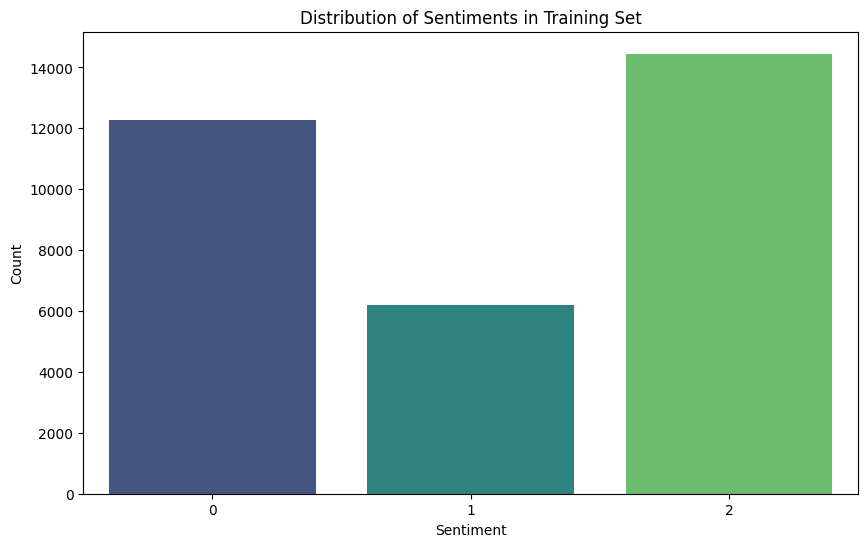

In [8]:
# Visualize the distribution of sentiments in the training set
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, data=X_train, palette='viridis')
plt.title('Distribution of Sentiments in Training Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

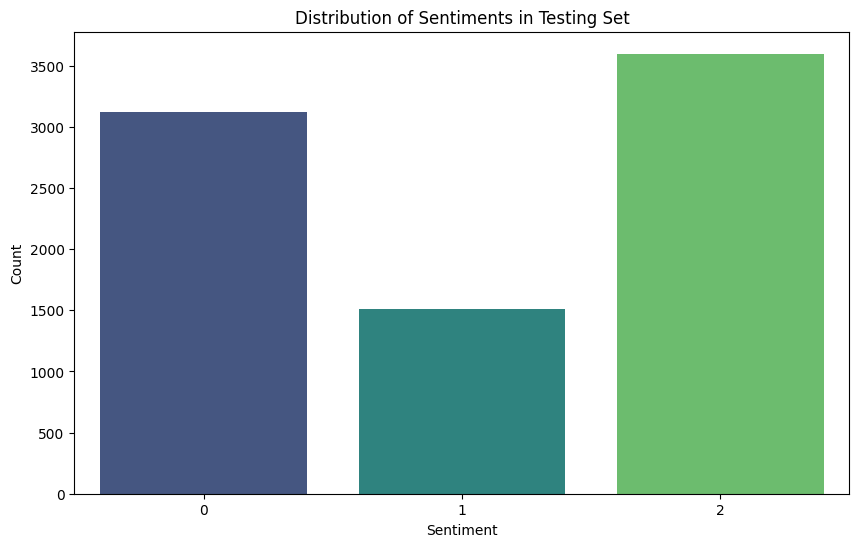

In [9]:
# Visualize the distribution of sentiments in the testing set
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test, data=X_test, palette='viridis')
plt.title('Distribution of Sentiments in Testing Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

    
    Create a GRU-based neural network model.

    Returns:
    model (Sequential): Compiled GRU model.
  

In [10]:
# Build the GRU model
def create_GRU_model():
    model = Sequential()
    # Embedding layer to convert words into dense vectors
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    # Bidirectional GRU layer for sequence processing
    model.add(Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
    # Additional GRU layer for further sequence processing
    model.add(GRU(64, dropout=0.3, recurrent_dropout=0.3))
     # Dense layer for non-linear transformation
    model.add(Dense(32, activation='relu'))
    # Dropout layer for regularization
    model.add(Dropout(0.5))
    # Output layer with softmax activation for multi-class classification
    model.add(Dense(3, activation='softmax'))
    return model


In [11]:
# Create and Compile the GRU Model

# Create the GRU model using the defined function
model = create_GRU_model()
# Set the learning rate for the Adam optimizer
learning_rate = 0.001
# Initialize the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early Stopping Callback

# Define early stopping to monitor validation loss and restore the best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model Training

# Train the model on the preprocessed and padded training data
# Use early stopping to prevent overfitting and restore the best weights
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/5
823/823 [==============================] - 491s 586ms/step - loss: 0.7033 - accuracy: 0.7041 - val_loss: 0.4988 - val_accuracy: 0.8210
Epoch 2/5
823/823 [==============================] - 470s 571ms/step - loss: 0.4157 - accuracy: 0.8669 - val_loss: 0.4537 - val_accuracy: 0.8454
Epoch 3/5
823/823 [==============================] - 476s 578ms/step - loss: 0.3328 - accuracy: 0.8979 - val_loss: 0.4825 - val_accuracy: 0.8460
Epoch 4/5
823/823 [==============================] - 437s 531ms/step - loss: 0.2773 - accuracy: 0.9167 - val_loss: 0.5357 - val_accuracy: 0.8416
Epoch 5/5
823/823 [==============================] - 421s 511ms/step - loss: 0.2319 - accuracy: 0.9281 - val_loss: 0.5903 - val_accuracy: 0.8281


In [12]:
# Testing
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

258/258 [==============================] - 22s 83ms/step


In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

Accuracy: 0.8506864293524481

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84      3123
           1       0.85      0.76      0.81      1511
           2       0.86      0.89      0.87      3597

    accuracy                           0.85      8231
   macro avg       0.85      0.83      0.84      8231
weighted avg       0.85      0.85      0.85      8231



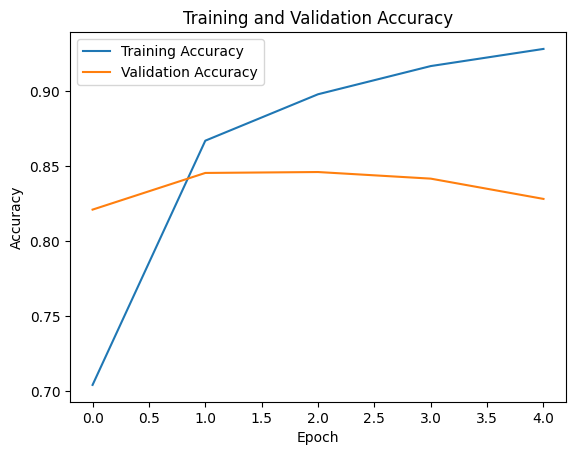

In [14]:
# Additional metrics and analysis
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

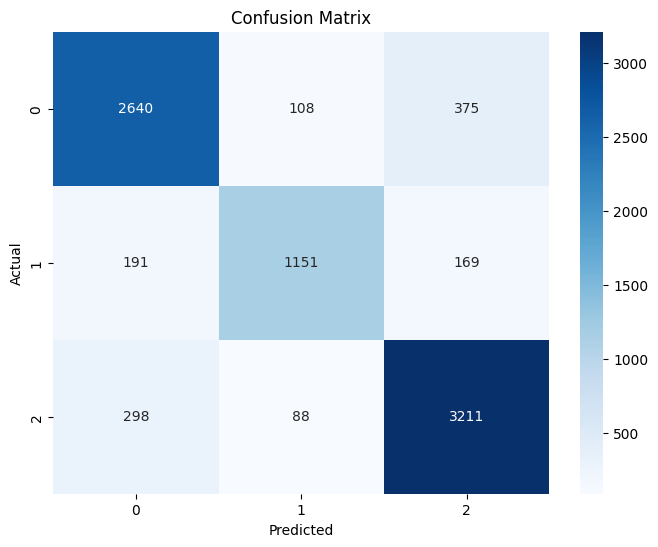

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
